In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import davies_bouldin_score, silhouette_score, normalized_mutual_info_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import OPTICS
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score


In [2]:
train_set = pd.read_csv("train.csv")
test_set = pd.read_csv("test.csv")
train_set.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
test_set.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
# кількість пропущених значень по стовпцях
train_missing = (train_set.isnull().sum() / train_set.isnull().count() * 100)
test_missing = (test_set.isnull().sum() / test_set.isnull().count() * 100)
missing_values = pd.concat([train_missing, test_missing], axis=1, keys=['Train', 'Test'])
missing_values

,Train,Test
PassengerId,0.000000,0.000000
Survived,0.000000,NaN
Pclass,0.000000,0.000000
Name,0.000000,0.000000
Sex,0.000000,0.000000
Age,19.865320,20.574163
SibSp,0.000000,0.000000
Parch,0.000000,0.000000
Ticket,0.000000,0.000000
Fare,0.000000,0.239234


In [5]:
# Розподіл числових фіч
train_set.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
# Розподіл нечислових фіч
train_set.describe(include='object')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [7]:
# Видалимо непотрібні стовпці та заповнимо пропуски 
train_columns_to_drop = ['PassengerId', 'Cabin', 'Ticket']
train_set_copy = train_set.drop(train_columns_to_drop, axis=1)

test_columns_to_drop = ['Cabin', 'Ticket']
test_set_copy = test_set.drop(test_columns_to_drop, axis=1)


train_set_copy['Embarked'].fillna(train_set_copy['Embarked'].mode()[0], inplace=True)
test_set_copy['Fare'].fillna(test_set_copy['Fare'].median(), inplace=True)

mean_age_by_pclass = train_set_copy.groupby('Pclass')['Age'].mean()
train_set_copy['Age'] = train_set_copy.apply(lambda row: mean_age_by_pclass[row['Pclass']] if pd.isnull(row['Age']) else row['Age'], axis=1)
test_set_copy['Age'] = test_set_copy.apply(lambda row: mean_age_by_pclass[row['Pclass']] if pd.isnull(row['Age']) else row['Age'], axis=1)
train_set_copy.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


In [8]:
# Введемо додаткові фічі для покращення якості моделі
for set in [train_set_copy, test_set_copy]:
    name = set['Name'].str

    set.drop('Name', axis=1, inplace=True)

    set['FamilySize'] = set['SibSp'] + set['Parch'] + 1
    set['IsAlone'] = 1
    set['IsAlone'].loc[set['FamilySize'] > 1] = 0
    set['Status'] = name.split(", ", expand = True)[1].str.split(".", expand = True)[0]

    set['FareBin'] = pd.qcut(set['Fare'], 4)
    set['AgeBin'] = pd.cut(set['Age'].astype(int), 5)


C:\Users\Bonnik\AppData\Local\Temp\ipykernel_14636\2901370506.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['IsAlone'].loc[df['FamilySize'] > 1] = 0
C:\Users\Bonnik\AppData\Local\Temp\ipykernel_14636\2901370506.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['IsAlone'].loc[df['FamilySize'] > 1] = 0


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Status,FareBin,AgeBin
0,0,3,male,22.0,1,0,7.2500,S,2,0,Mr,"(-0.001, 7.91]","(16.0, 32.0]"
1,1,1,female,38.0,1,0,71.2833,C,2,0,Mrs,"(31.0, 512.329]","(32.0, 48.0]"
2,1,3,female,26.0,0,0,7.9250,S,1,1,Miss,"(7.91, 14.454]","(16.0, 32.0]"
3,1,1,female,35.0,1,0,53.1000,S,2,0,Mrs,"(31.0, 512.329]","(32.0, 48.0]"
4,0,3,male,35.0,0,0,8.0500,S,1,1,Mr,"(7.91, 14.454]","(32.0, 48.0]"


In [9]:
# Кодування категоріальних фіч у числові
labelEncoder = LabelEncoder()
categorical_features = ['Sex', 'Embarked', 'Status', 'FareBin', 'AgeBin']
coded_features = []
for set in [train_set_copy, test_set_copy]:
    for feature in categorical_features:
        code_column_name = feature + "_coded"
        set[code_column_name] = labelEncoder.fit_transform(set[feature])
        coded_features.append(code_column_name)

In [10]:
# Зробимо One-Hot Encoding категоріальних фіч
train_set_copy = pd.get_dummies(train_set_copy, columns=coded_features, drop_first=True, dtype=int)
train_set_copy.drop(categorical_features, axis=1, inplace=True)
test_set_copy = pd.get_dummies(test_set_copy, columns=coded_features, drop_first=True, dtype=int)
test_set_copy.drop(categorical_features, axis=1, inplace=True)
train_set_copy.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize,IsAlone,Sex_coded_1,Embarked_coded_1,...,Status_coded_14,Status_coded_15,Status_coded_16,FareBin_coded_1,FareBin_coded_2,FareBin_coded_3,AgeBin_coded_1,AgeBin_coded_2,AgeBin_coded_3,AgeBin_coded_4
0,0,3,22.0,1,0,7.2500,2,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,1,1,38.0,1,0,71.2833,2,0,0,0,...,0,0,0,0,0,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,1,0,0,...,0,0,0,1,0,0,1,0,0,0
3,1,1,35.0,1,0,53.1000,2,0,0,0,...,0,0,0,0,0,1,0,1,0,0
4,0,3,35.0,0,0,8.0500,1,1,1,0,...,0,0,0,1,0,0,0,1,0,0


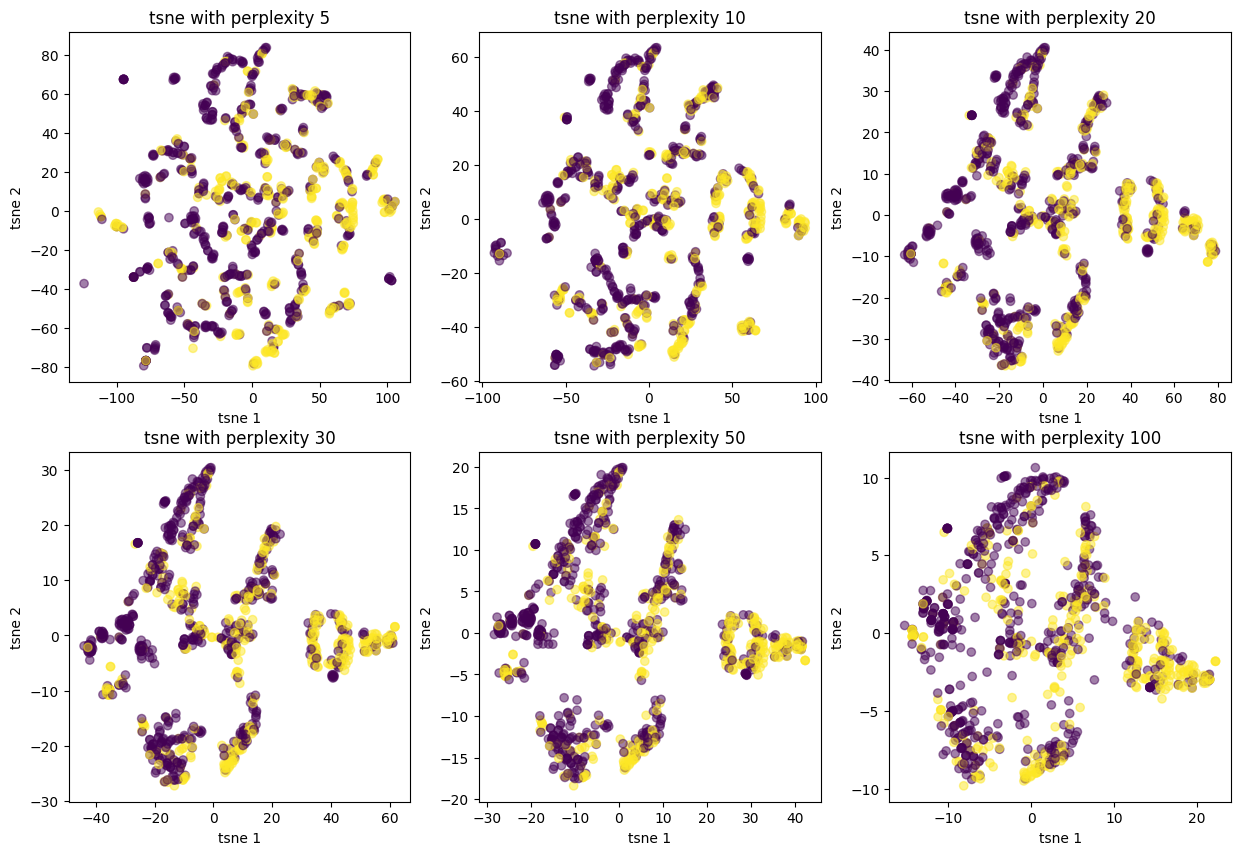

In [16]:
X_train = train_set_copy.drop('Survived', axis=1)
perplexities = [5, 10, 20, 30, 50, 100]
X_tsne_dictionary = {}

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, perplexity in enumerate(perplexities):
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    X_tsne = tsne.fit_transform(X_train)
    X_tsne_dictionary[perplexity] = X_tsne

    row = i // 3
    col = i % 3
    axes[row, col].scatter(X_tsne[:, 0], X_tsne[:, 1], c=train_set_copy['Survived'], cmap='viridis', alpha=0.5)
    axes[row, col].set_title('tsne with perplexity ' + str(perplexity))
    axes[row, col].set_xlabel('tsne 1')
    axes[row, col].set_ylabel('tsne 2')

plt.show()

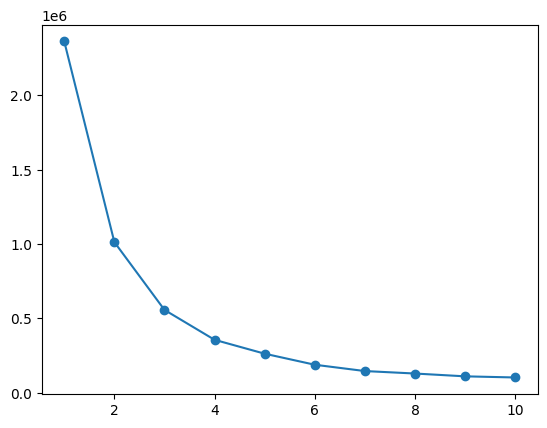

In [15]:
# за допомогою SSE визначимо оптимальну кількість кластерів (в даному випадку 3)
sse_dictionary = {}
inertias = []
k_range = range(1, 11)
for k in k_range:
    k_means = KMeans(n_clusters=k, random_state=42)
    k_means.fit(X_train)
    sse_dictionary[k] = k_means
    inertias.append(k_means.inertia_)

plt.plot(k_range, inertias, marker='o')
plt.show()

In [17]:
# Встановлення параметрів методу кластеризації DBSCAN
param_grid = {'eps': [0.1, 0.5, 1.0], 'min_samples': [100, 200, 500]}
dbscan = DBSCAN(metric='hamming')
grid_search = GridSearchCV(dbscan, param_grid, scoring=silhouette_score, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train)
best_parameters = grid_search.best_params_
dbscan_model = grid_search.best_estimator_
print('Best params:', best_parameters)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best params: {'eps': 0.1, 'min_samples': 100}


C:\Users\Bonnik\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan]
  warnings.warn(


In [18]:
# Встановлення параметрів агломеративного методу кластеризації
param_grid = {'n_clusters': [2, 3, 4, 5, 6], 'linkage': ['complete', 'average', 'single']}
agg_clustering = AgglomerativeClustering(metric='hamming')
grid_search = GridSearchCV(agg_clustering, param_grid, scoring=silhouette_score, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train)
best_parameters = grid_search.best_params_
agg_model = grid_search.best_estimator_
print('Best parameters:', best_parameters)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best parameters: {'linkage': 'complete', 'n_clusters': 2}


C:\Users\Bonnik\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


In [20]:
min_samples = [10, 50, 100, 200, 300]
max_eps_range = np.linspace(0.01, 1)
metric = 'hamming'

best_score = -1
best_parameters = None
best_model = None

for min_sample in min_samples:
    for max_eps in max_eps_range:
        optics = OPTICS(min_samples=min_sample, max_eps=max_eps, metric=metric)
        optics.fit(X_train)
        labels = optics.labels_

        if len(np.unique(labels)) > 1:
            silhouette = silhouette_score(X_train, labels)
            if silhouette > best_score:
                best_score = silhouette
                best_parameters = {'min_samples': min_sample, 'max_eps': max_eps}
                best_model = optics

print('Best parameters: ', best_parameters)
optics_model = best_model

C:\Users\Bonnik\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
C:\Users\Bonnik\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
C:\Users\Bonnik\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
C:\Users\Bonnik\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
C:\Users\Bonnik\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot

Best parameters:  {'min_samples': 300, 'max_eps': 0.19183673469387755}


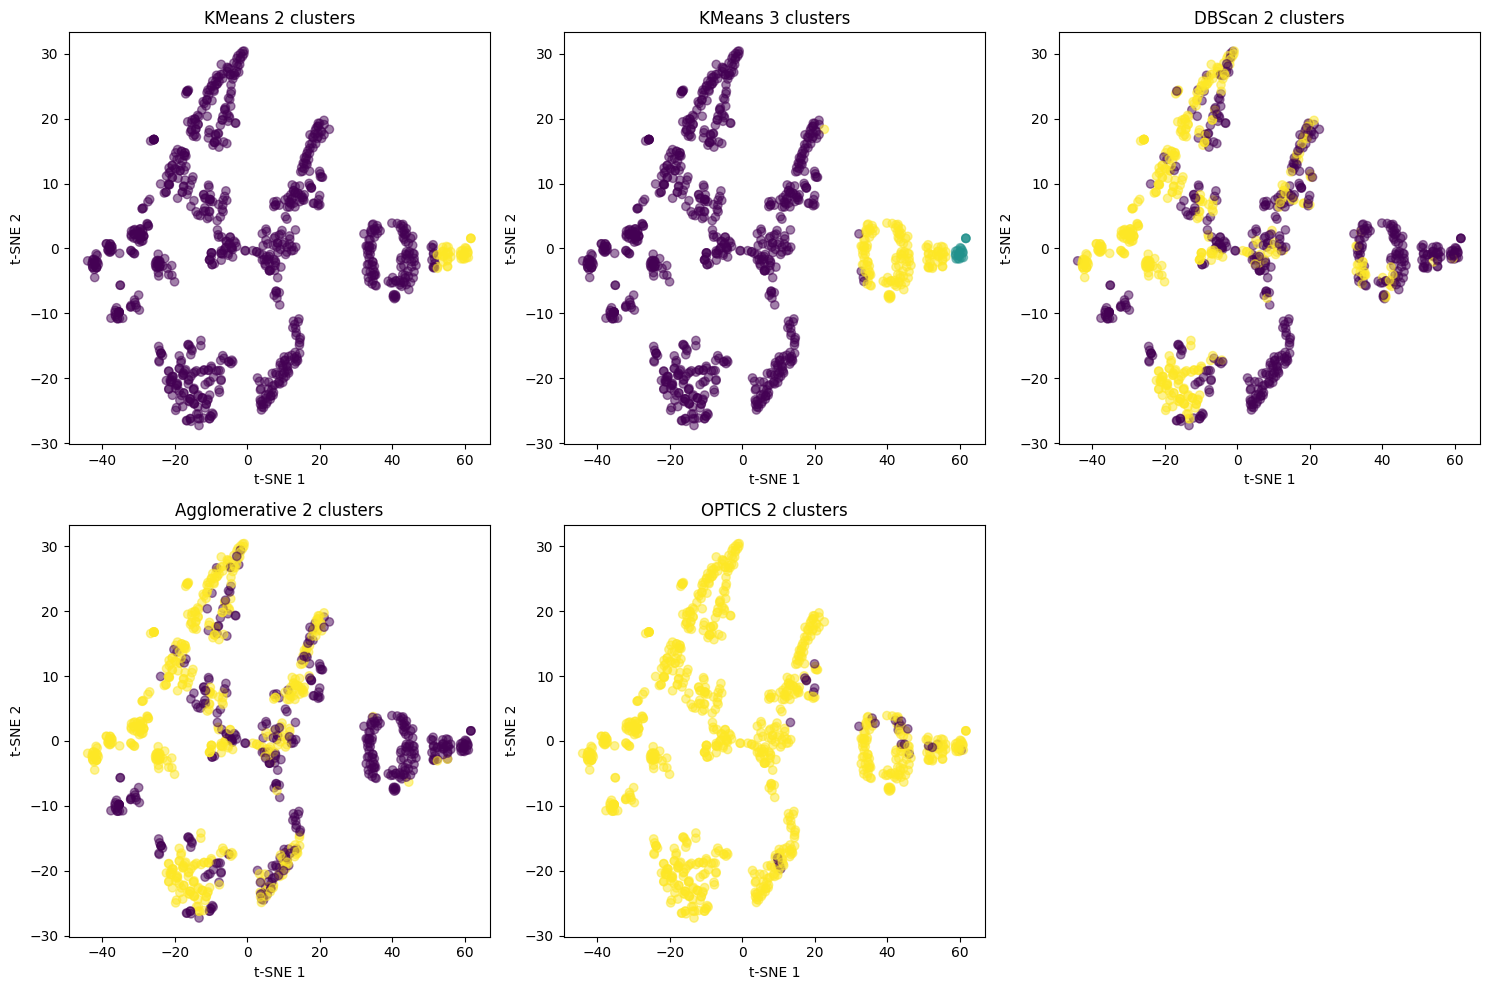

In [21]:
# Покажемо результати кластеризації для кількох моделей
cluster_models = {
    'KMeans 2 clusters': sse_dictionary[2],
    'KMeans 3 clusters': sse_dictionary[3],
    f'DBScan {len(np.unique(dbscan_model.labels_))} clusters': dbscan_model,
    f'Agglomerative {agg_model.n_clusters_} clusters': agg_model,
    f'OPTICS {len(np.unique(optics_model.labels_))} clusters': optics_model
}

num_cols = 3
num_rows = len(cluster_models) // num_cols + (len(cluster_models) % num_cols > 0)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

for i, (model_name, model) in enumerate(cluster_models.items()):
    X_tsne = X_tsne_dictionary[30]
    labels = model.labels_

    row = i // num_cols
    col = i % num_cols

    axes[row, col].scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis', alpha=0.5)
    axes[row, col].set_title(model_name)
    axes[row, col].set_xlabel('t-SNE 1')
    axes[row, col].set_ylabel('t-SNE 2')

if len(cluster_models) % num_cols != 0:
    for j in range(len(cluster_models) % num_cols, num_cols):
        fig.delaxes(axes[num_rows-1, j])

plt.tight_layout()
plt.show()

In [26]:
#Оцінимо якість кластеризації (бачимо, що в даному випадку найкраще працює метод агломеративної кластеризації)
true_labels = train_set_copy['Survived']
cluster_labels = {}

for model_name, model in cluster_models.items():
    predicted_labels = model.labels_

    cluster_labels[model_name] = predicted_labels

for model_name, predicted_labels in cluster_labels.items():
    ari = adjusted_rand_score(true_labels, predicted_labels)
    nmi = normalized_mutual_info_score(true_labels, predicted_labels)
    print(f"{model_name}: ARI = {ari}, NMI = {nmi}")

KMeans 2 clusters: ARI = 0.03651409725228758, NMI = 0.03425751464402948
KMeans 3 clusters: ARI = 0.10683606698846633, NMI = 0.06351475294544257
DBScan 2 clusters: ARI = 0.1837541008899126, NMI = 0.163360864657984
Agglomerative 2 clusters: ARI = 0.2307026964655891, NMI = 0.1735020335999911
OPTICS 2 clusters: ARI = 0.016817144114953924, NMI = 0.012742323303991145
